In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import tensorflow as tf
from scipy.signal import butter, filtfilt


In [2]:
# Set memory limit for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)]
            )
        print("Memory limit set to 4000 MB for each GPU.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found.")


Memory limit set to 4000 MB for each GPU.


In [3]:
# Parameters
target_sample_rate = 8000
n_fft = 2048
hop_length = 512
n_mels = 128
clip_duration = 5
target_width = 128
negative_dir = 'dataset_full/negative'
weevil_dir = 'dataset_full/rice_weevil'
rd_dir = 'dataset_full/r_dominica'
tc_dir = 'dataset_full/t_castaneum'

In [4]:
low_cutoff = 93.75  # Low-pass cut-off frequency in Hz
high_cutoff = 2500  # High-pass cut-off frequency in Hz
filter_order = 4    # Order of the filter

# Butterworth band-pass filter
def butter_bandpass(lowcut, highcut, sr, order=4):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Applying band-pass filter to an audio signal
def bandpass_filter(data, lowcut, highcut, sr, order=4):
    b, a = butter_bandpass(lowcut, highcut, sr, order=order)
    y = filtfilt(b, a, data)  # Apply the filter to the data
    return y

# audio = bandpass_filter(
#         audio, lowcut=low_cutoff, highcut=high_cutoff,
#         sr=target_sample_rate, order=filter_order
#     )

In [5]:
def preprocess_audio(file_path, duration):
    """
    Preprocess an audio file by segmenting it into clips of the specified duration
    and resizing the spectrogram to a fixed width.
    Args:
        file_path (str): Path to the audio file.
        duration (int): Duration of each clip in seconds (e.g., 5 seconds).
    Returns:
        List of processed spectrograms.
    """
    # Load the audio file
    audio, _ = librosa.load(file_path, sr=target_sample_rate)
    
    # Normalize the audio
    audio = audio / np.max(np.abs(audio))
    
    # Define clip length in samples
    clip_samples = int(duration * target_sample_rate)
    segments = []
    
    # Segment the audio into non-overlapping clips of specified duration
    for i in range(0, len(audio), clip_samples):
        clip = audio[i:i + clip_samples]
        
        # If the clip is shorter than the target duration, pad it with zeros
        if len(clip) < clip_samples:
            clip = np.pad(clip, (0, clip_samples - len(clip)), mode='constant')
        
        # Generate Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=clip, sr=target_sample_rate, 
                                                         n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        # Resize the spectrogram to the target width by padding or truncating
        if log_mel_spectrogram.shape[1] < target_width:
            padding = target_width - log_mel_spectrogram.shape[1]
            log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, padding)), mode='constant')
        else:
            log_mel_spectrogram = log_mel_spectrogram[:, :target_width]
        
        # Normalize the spectrogram
        log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean()) / log_mel_spectrogram.std()
        
        # Reshape for CNN (height, width, channels)
        log_mel_spectrogram = log_mel_spectrogram.reshape((n_mels, target_width, 1))
        
        # Append the processed spectrogram
        segments.append(log_mel_spectrogram)
    
    return segments

In [6]:
# Initialize lists to store processed spectrograms and labels
all_spectrograms = []
labels = []

# Define directory paths for each class
directories = {
    'negative': negative_dir,
    'rice_weevil': weevil_dir,
    'r_dominica': rd_dir,
    't_castaneum': tc_dir
}

# Define labels for each class
class_labels = {
    'negative': 0,
    'rice_weevil': 1,
    'r_dominica': 2,
    't_castaneum': 3
}

# Process audio files in each directory
for class_name, dir_path in directories.items():
    label = class_labels[class_name]
    
    for filename in os.listdir(dir_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(dir_path, filename)
            
            # Preprocess the audio file into spectrogram segments
            spectrograms = preprocess_audio(file_path, duration=5)
            
            # Append each segment and its label to the dataset
            all_spectrograms.extend(spectrograms)
            labels.extend([label] * len(spectrograms))

# Convert lists to numpy arrays for model input
all_spectrograms = np.array(all_spectrograms)
labels = np.array(labels)

print("Spectrograms shape:", all_spectrograms.shape)  # Should be (num_samples, height, width, channels)
print("Labels shape:", labels.shape)  # Should be (num_samples,)

Spectrograms shape: (27830, 128, 128, 1)
Labels shape: (27830,)


In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [8]:
labels = to_categorical(labels, num_classes=4)

In [9]:
# Splitting the dataset to train, test, validation
X_train, X_temp, y_train, y_temp = train_test_split(
    all_spectrograms, labels,
    test_size=0.3,
    random_state=42
    )

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42
    )

In [10]:
# Creating CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(4, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=25,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True
                               )

checkpoint = ModelCheckpoint('cnn_weevil_full.h5',
                             save_best_only=True
                             )

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/150
609/609 [==============================] - 22s 30ms/step - loss: 1.8453 - accuracy: 0.7097 - val_loss: 1.0062 - val_accuracy: 0.8690
Epoch 2/150
609/609 [==============================] - 17s 28ms/step - loss: 0.8912 - accuracy: 0.8687 - val_loss: 0.7380 - val_accuracy: 0.8946
Epoch 3/150
609/609 [==============================] - 17s 28ms/step - loss: 0.7022 - accuracy: 0.8899 - val_loss: 0.6233 - val_accuracy: 0.9006
Epoch 4/150
609/609 [==============================] - 17s 28ms/step - loss: 0.6067 - accuracy: 0.9011 - val_loss: 0.5332 - val_accuracy: 0.9221
Epoch 5/150
609/609 [==============================] - 17s 28ms/step - loss: 0.5454 - accuracy: 0.9099 - val_loss: 0.4776 - val_accuracy: 0.9281
Epoch 6/150
609/609 [==============================] - 17s 28ms/step - loss: 0.5070 - accuracy: 0.9138 - val_loss: 0.4479 - val_accuracy: 0.9272
Epoch 7/150
609/609 [==============================] - 19s 31ms/step - loss: 0.4691 - accuracy: 0.9200 - val_loss: 0.4185 - val_ac

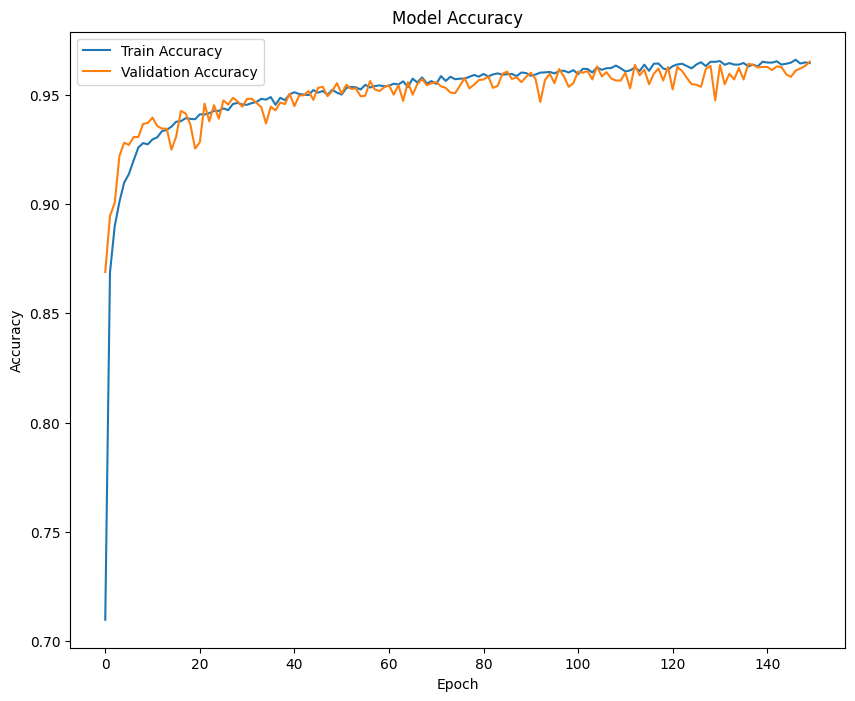

In [13]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

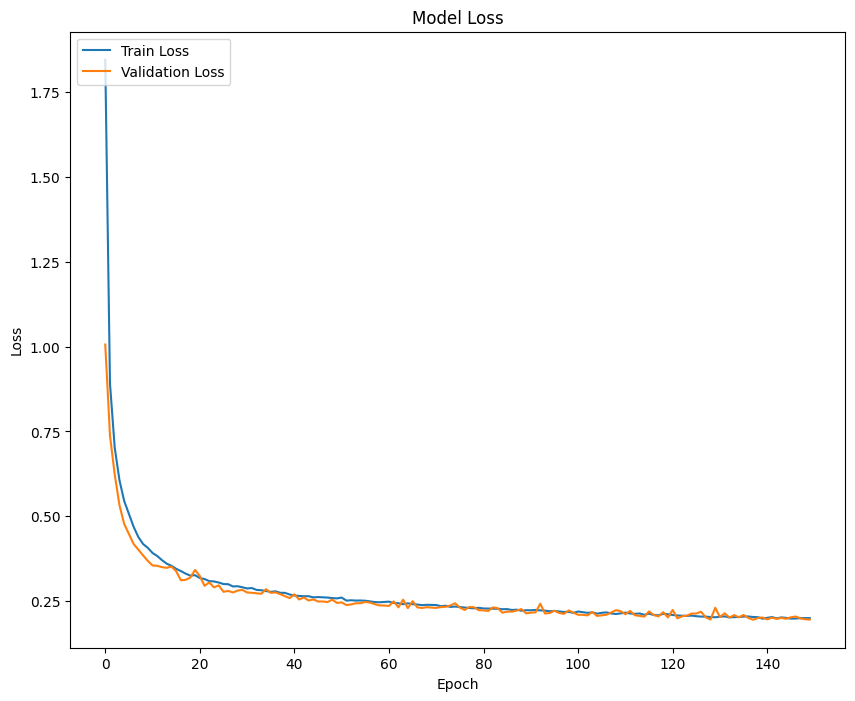

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

131/131 [==============================] - 2s 12ms/step - loss: 0.1945 - accuracy: 0.9624
Test accuracy: 0.9624
Test loss: 0.1945


In [16]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

131/131 [==============================] - 1s 7ms/step


In [17]:
true_labels = np.argmax(y_test, axis=1)

report = classification_report(true_labels, predicted_labels, target_names=["negative", "rice_weevil", "r_dominica", "t_castaneum"])
print(report)

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       289
 rice_weevil       0.92      0.97      0.95      1276
  r_dominica       0.97      0.92      0.94      1296
 t_castaneum       0.99      0.99      0.99      1314

    accuracy                           0.96      4175
   macro avg       0.97      0.97      0.97      4175
weighted avg       0.96      0.96      0.96      4175



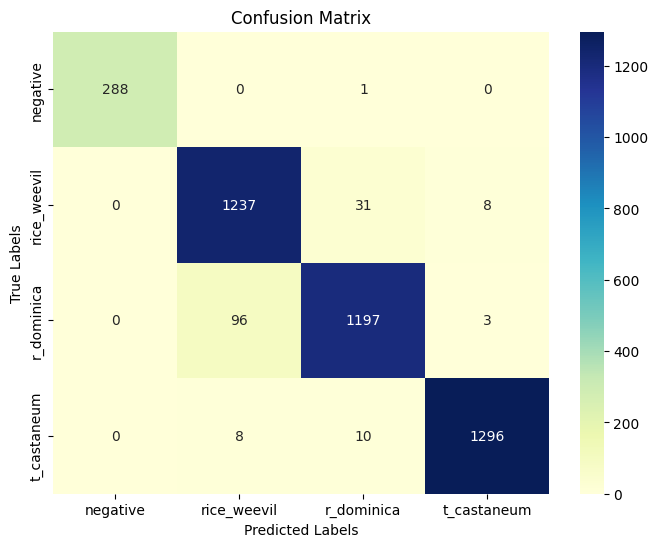

In [18]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["negative", "rice_weevil", "r_dominica", "t_castaneum"], yticklabels=["negative", "rice_weevil", "r_dominica", "t_castaneum"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
